In [3]:
import db
import networkx as nx
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import os

In [4]:
# must set JAVA_HOME environment to point to local JDK
# also it seems like we need Java 11 to run some of the libraries
os.environ["JAVA_HOME"] = "/usr/local/opt/openjdk@11/"

In [5]:
# setup Apache Spark

from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark

# this path needs to point your local copy of Spark
# here we downloaded Spark into our local directory
findspark.init("./spark-3.2.0-bin-hadoop3.2")

# start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/18 22:25:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/11/18 22:25:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/11/18 22:25:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/11/18 22:25:35 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
21/11/18 22:25:35 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
21/11/18 22:25:35 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [54]:
# plotting function
def plot_graph(edges):
    plt.figure(figsize=(30,20))
    g = nx.Graph()
    g = nx.from_pandas_edgelist(edges, 'src', 'dst')
    nx.draw(g, with_labels=False, arrows=False, node_color='grey', node_size=50)
    plt.show()

In [6]:
# connect to the Postgres database server using our db utilities
connection = db.connect()
# grab the cursor
cursor = connection.cursor()

# Perform Analysis on All Cases

In this section we perform our graph analysis on all TRR cases, whereas in the next section we will peform the same analysis on cross-race TRR cases.

In [7]:
# fetch the timestamp edges
# this will be our baseline
cursor.execute("""
    SELECT d1.officer_id src, d2.officer_id dst, COUNT(*) shifts_worked
    FROM data_officerassignmentattendance d1
        JOIN data_officerassignmentattendance d2 
        ON d1.start_timestamp = d2.start_timestamp 
            AND d1.beat_id = d2.beat_id 
            AND d1.officer_id < d2.officer_id
    WHERE d1.present_for_duty AND d2.present_for_duty
    GROUP BY d1.officer_id, d2.officer_id;
""")
tsedges = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [8]:
# fetch our TRR edges
cursor.execute("""
    SELECT t1.officer_id src, t1.subject_race sub_race,
            t2.officer_id dst, COUNT(DISTINCT t1.event_id)
    FROM trr_trr t1
        JOIN trr_trr t2 ON t1.event_id = t2.event_id AND t1.officer_id < t2.officer_id
    GROUP BY t1.officer_id, t2.officer_id, t1.subject_race
    ORDER BY count(DISTINCT t1.event_id) DESC;
""")
edges = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [12]:
# fetch our nodes
cursor.execute("""
    SELECT  id, first_name || ' ' || last_name "name", trr_count
    FROM data_officer
    WHERE id IN (SELECT DISTINCT  officer_id FROM trr_trr);
""")
nodes = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [13]:
# this function modifies the edges from directed to undirected
# we need to do this for PageRank analysis
def to_undirected(edges):
    edges_reverse = edges.copy(deep=True)
    edges_reverse['tmp'] = edges_reverse['src']
    edges_reverse['src'] = edges_reverse['dst']
    edges_reverse['dst'] = edges_reverse['tmp']
    edges_reverse = edges_reverse.drop(columns=['tmp'])
    return pd.concat([edges, edges_reverse])

In [15]:
# map to undirected edges
undirected_edges = to_undirected(edges)

In [17]:
# compute the PageRank on the undirected edges
pagerank = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(undirected_edges), # use undirected edges for PageRank
).pageRank(
    resetProbability=0.15,
    tol=0.01,
).vertices.toPandas().sort_values(
    'pagerank',
    ascending=False,
)

In [18]:
pagerank

,id,name,trr_count,pagerank
10419,10583,George Granias,72,8.023228
4876,21371,Phillip Orlando,41,7.699965
415,14400,Patrick Kelly,62,6.832329
8791,32118,Cesar Kuri,65,6.710494
3544,28970,Jeff Truhlar,37,6.047544
...,...,...,...,...
7797,3053,Alton Brown,2,0.181987
7796,24821,Valery Roytman,1,0.181987
7785,15869,Karen Leader,2,0.181987
7759,2005,Steven Bigden,1,0.181987


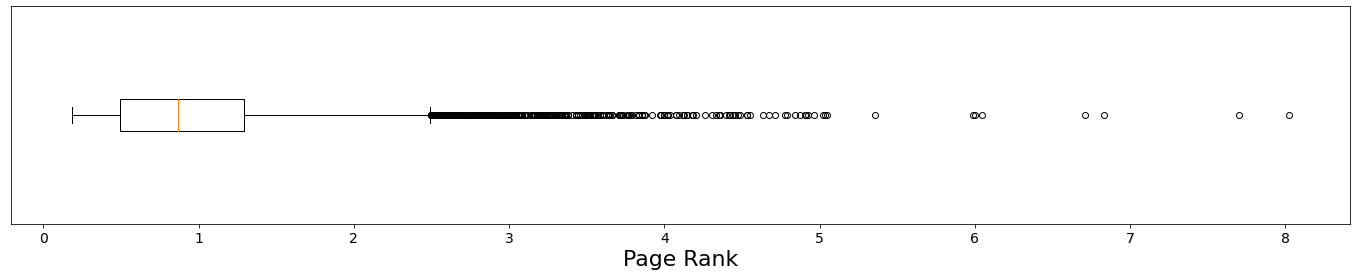

In [19]:
# plot the figure for PageRank value distribution
plt.figure(figsize=(24,4))
plt.boxplot(pagerank['pagerank'], vert=False)
plt.xticks(fontsize=14)
plt.yticks([])
plt.xlabel('Page Rank', fontsize=22)
plt.show()

In [20]:
# compute the triangle count
triangles = GraphFrame(
    spark.createDataFrame(nodes),
    spark.createDataFrame(edges),
).triangleCount().toPandas().sort_values(by=['count'], ascending=False)

In [22]:
triangles

,count,id,name,trr_count
10154,206,21371,Phillip Orlando,41
6969,182,13313,Steve Jarosz,20
6046,180,11615,Ryan Harty,22
6426,162,30561,Wayne Wiberg,30
10370,148,10583,George Granias,72
...,...,...,...,...
3559,0,2093,Darrion Blackburn,5
3556,0,6006,Jonathan Cwynar,3
3555,0,22835,Joseph Porebski,1
3551,0,30884,James Williamson,1


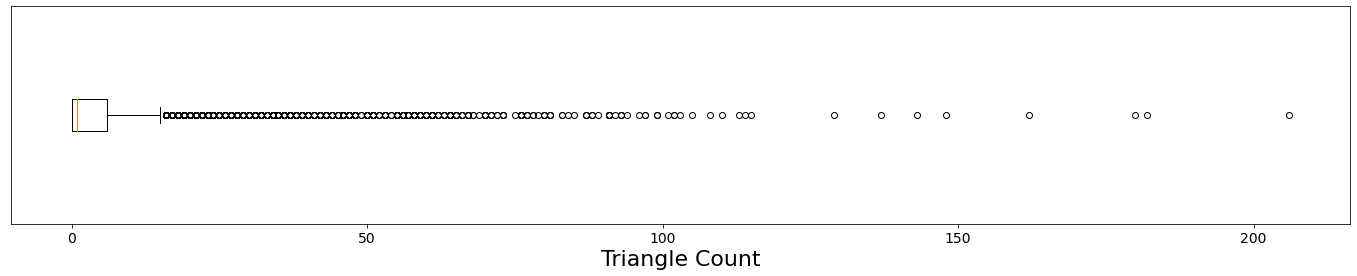

In [50]:
# plot the figure for triangle count value distribution
plt.figure(figsize=(24,4))
plt.boxplot(triangles['count'], vert=False)
plt.xticks(fontsize=14)
plt.yticks([])
plt.xlabel('Triangle Count', fontsize=22)
plt.show()

In [26]:
# choose the top 50 officers with most triangle counts
interested = set(triangles[:50]['id'])

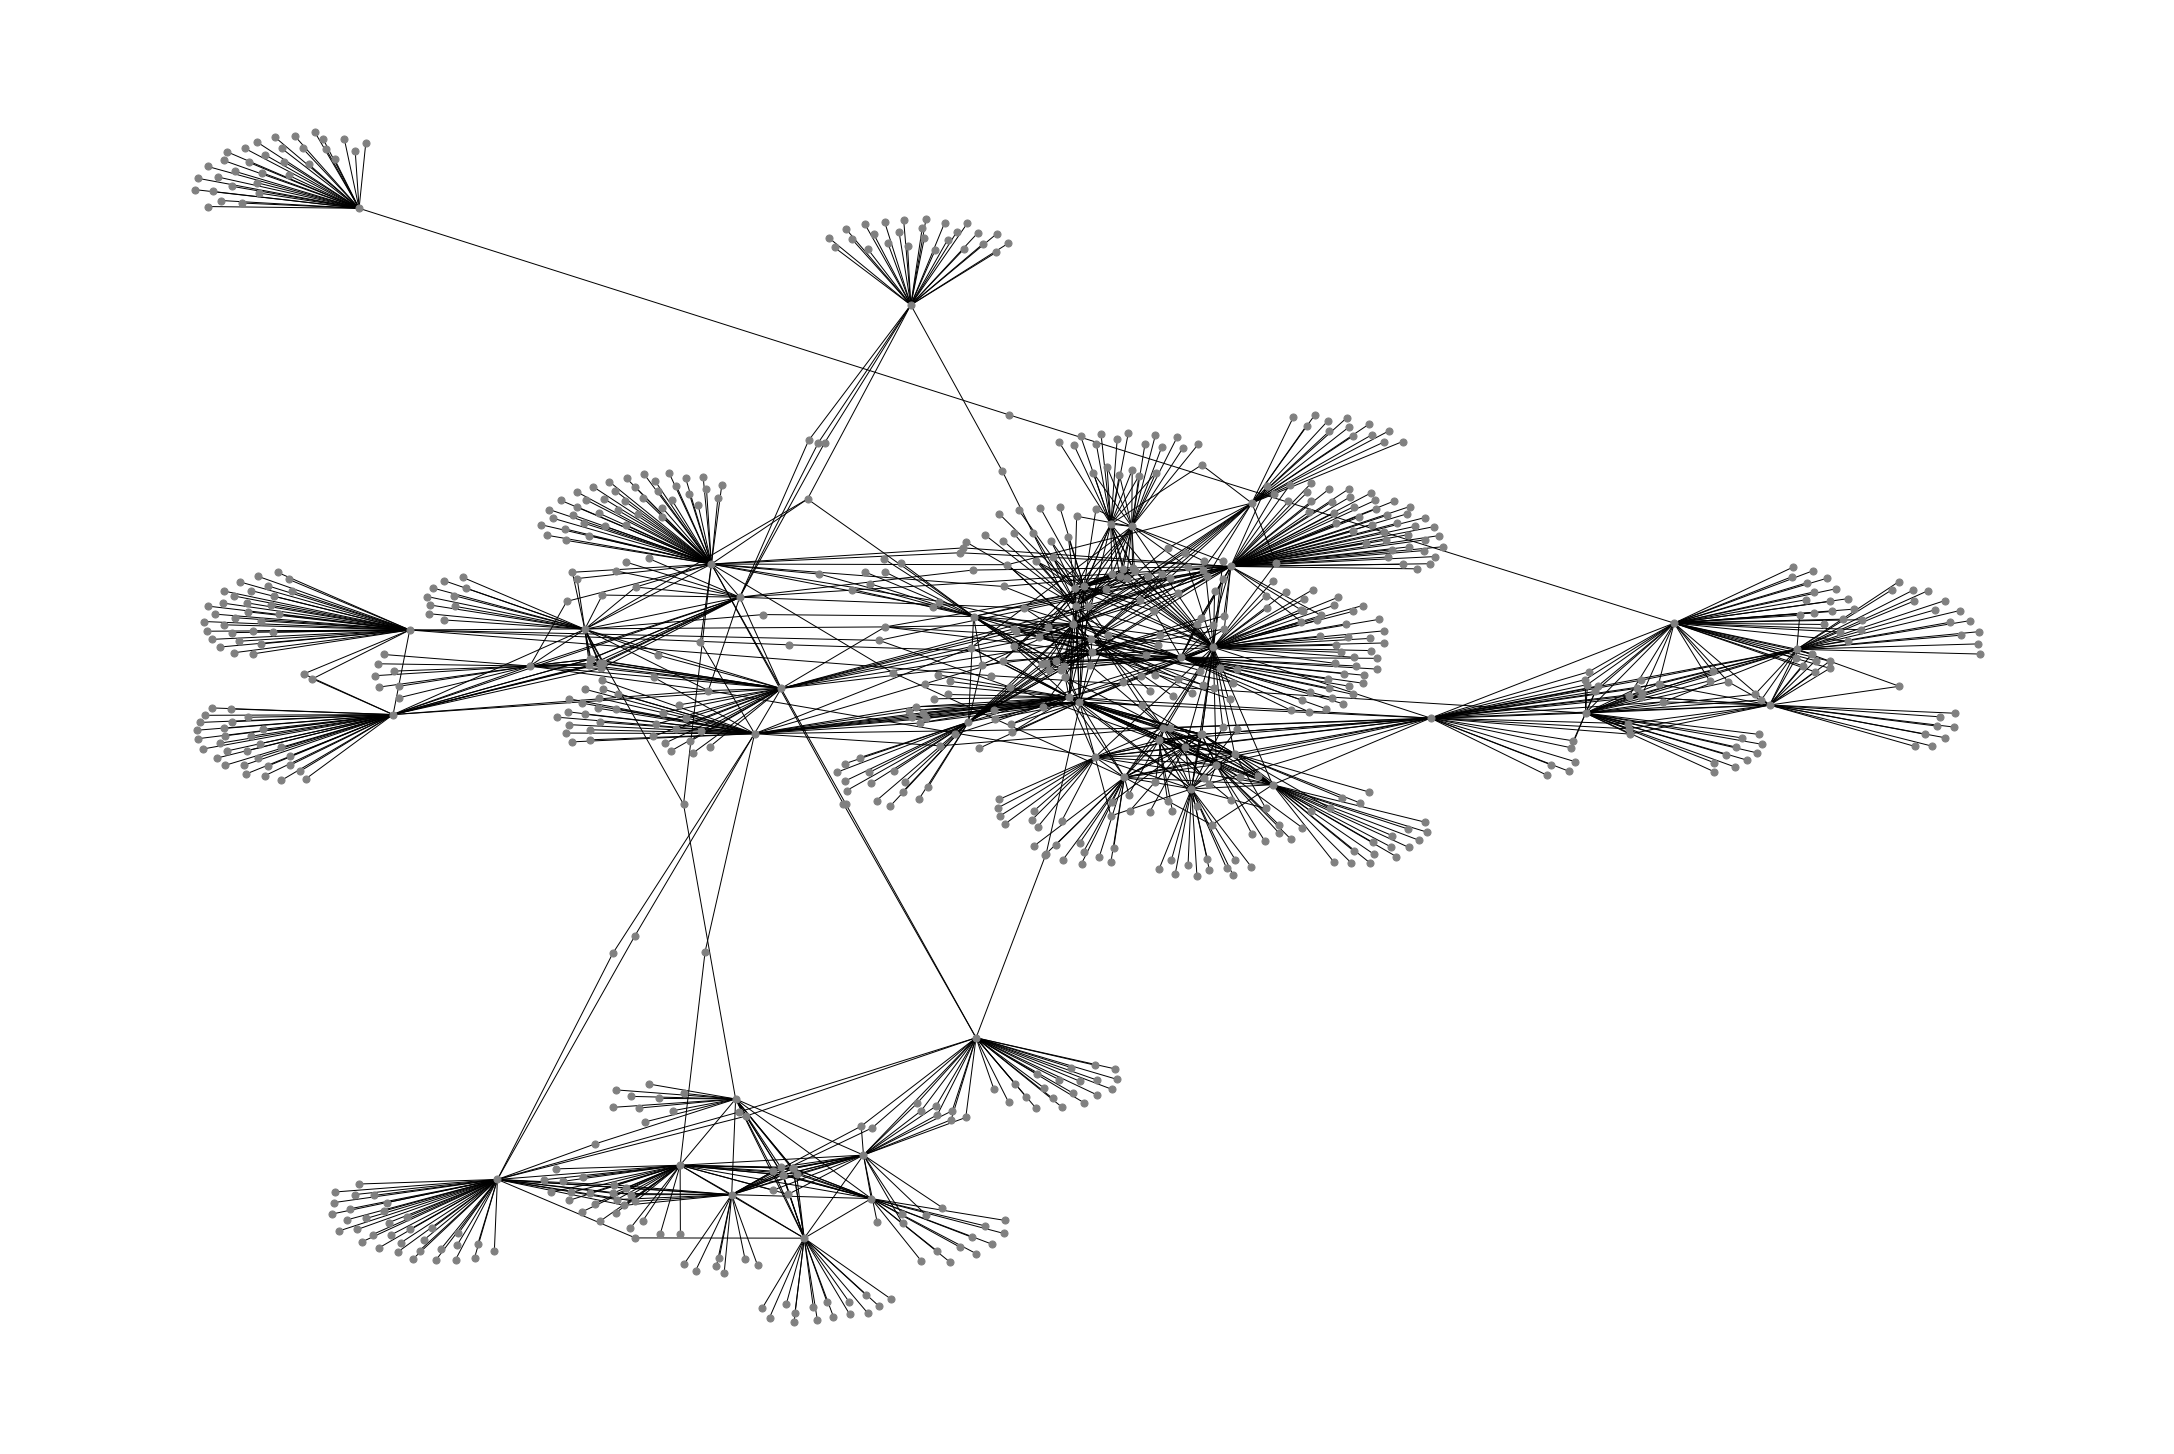

In [28]:
# plot TRR network graph
plot_graph(edges[(edges['src'].isin(interested)) | (edges['dst'].isin(interested))])

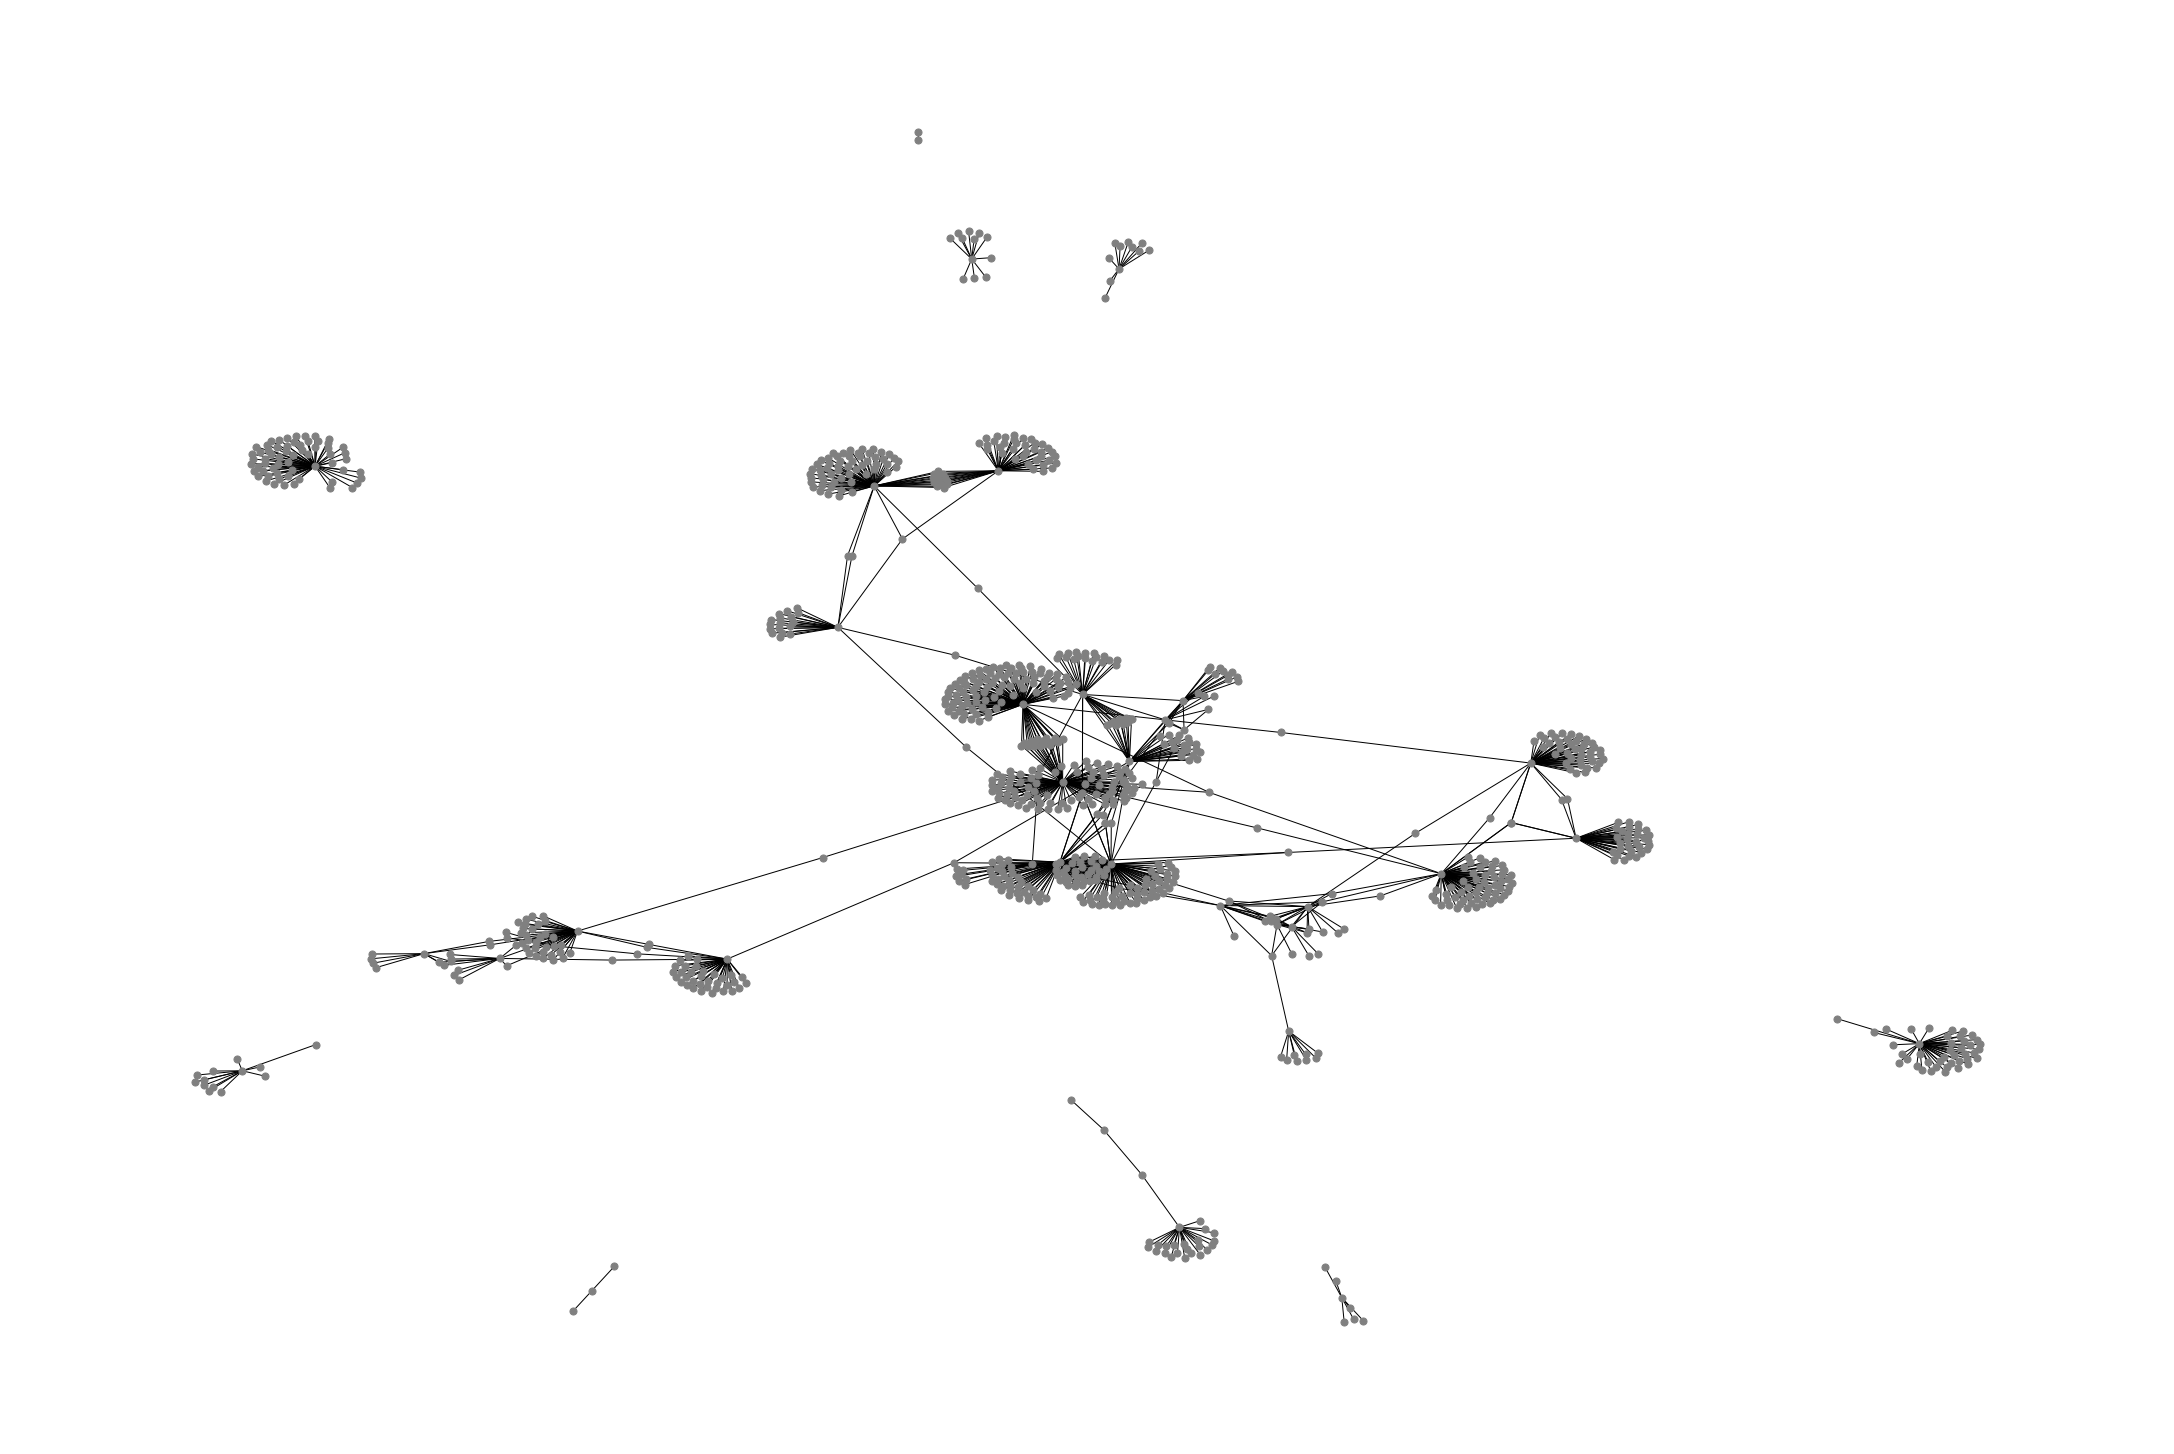

In [29]:
# plot baseline graph
plot_graph(tsedges[(tsedges['src'].isin(interested)) | (tsedges['dst'].isin(interested))])

# Perform on Cross-Race TRR

In this section we perform our graph analysis on cross-race TRR cases.

In [30]:
cursor.execute("""
    SELECT d1.officer_id src, d2.officer_id dst, COUNT(*) shifts_worked
    FROM data_officerassignmentattendance d1
        JOIN data_officerassignmentattendance d2 
        ON d1.start_timestamp = d2.start_timestamp 
            AND d1.beat_id = d2.beat_id 
            AND d1.officer_id < d2.officer_id
    WHERE d1.present_for_duty AND d2.present_for_duty
    GROUP BY d1.officer_id, d2.officer_id;
""")
tsedges_cr = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [31]:
cursor.execute("""
    SELECT t1.officer_id src, t1.subject_race sub_race,
            t2.officer_id dst, COUNT(DISTINCT t1.event_id)
    FROM trr_trr t1
        JOIN trr_trr t2 ON t1.event_id = t2.event_id AND t1.officer_id < t2.officer_id
    GROUP BY t1.officer_id, t2.officer_id, t1.subject_race
    ORDER BY count(DISTINCT t1.event_id) DESC;
""")
edges_cr = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [32]:
cursor.execute("""
    SELECT  id, first_name || ' ' || last_name "name", trr_count, race
    FROM data_officer
    WHERE id IN (SELECT DISTINCT  officer_id FROM trr_trr);
""")
nodes_cr = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [33]:
# cleanup nodes race data discrepancies
nodes_cr['race'] = nodes_cr['race'].str.upper().replace('ASIAN/PACIFIC', 'ASIAN/PACIFIC ISLANDER')

In [36]:
# first process the data to include only cross-race cases
edges_cr = edges_cr.join(nodes_cr.set_index('id'), on=['src'])
edges_cr = edges_cr.drop(columns=['name', 'trr_count'])
edges_cr = edges_cr.rename(columns = {'race': 'off_race'})
edges_cr = edges_cr[edges_cr['off_race'] != edges_cr['sub_race']]
edges_cr

,src,sub_race,dst,count,off_race
0,17634,BLACK,29992,18,WHITE
1,1444,BLACK,29209,16,HISPANIC
2,3802,BLACK,23950,13,WHITE
3,31898,BLACK,32428,13,WHITE
4,15767,BLACK,29529,13,WHITE
...,...,...,...,...,...
30666,1440,BLACK,18850,1,WHITE
30667,1444,BLACK,20939,1,HISPANIC
30668,1444,BLACK,23786,1,HISPANIC
30669,1444,BLACK,27929,1,HISPANIC


In [40]:
# map to undirected edges
undirected_edges_cr = to_undirected(edges_cr)

In [41]:
# compute the PageRank on the undirected edges
pagerank_cr = GraphFrame(
    spark.createDataFrame(nodes_cr),
    spark.createDataFrame(undirected_edges_cr), # use undirected edges for PageRank
).pageRank(
    resetProbability=0.15,
    tol=0.01,
).vertices.toPandas().sort_values(
    'pagerank',
    ascending=False,
)

In [42]:
pagerank_cr

,id,name,trr_count,race,pagerank
10419,10583,George Granias,72,NATIVE AMERICAN/ALASKAN NATIVE,9.749685
8791,32118,Cesar Kuri,65,HISPANIC,7.859295
4876,21371,Phillip Orlando,41,HISPANIC,7.784808
415,14400,Patrick Kelly,62,WHITE,7.631076
3544,28970,Jeff Truhlar,37,WHITE,7.005623
...,...,...,...,...,...
685,17544,Arnold Martinez,3,HISPANIC,0.203569
8541,26558,Anthony Skokal,2,WHITE,0.203569
5186,30603,Mark Wiktorek,1,WHITE,0.203569
5185,6395,Arthur Davis,5,BLACK,0.203569


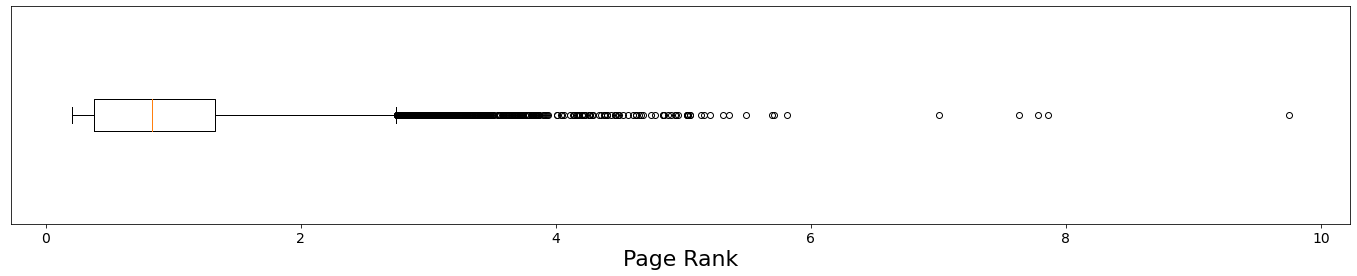

In [45]:
# plot the figure for PageRank value distribution
plt.figure(figsize=(24,4))
plt.boxplot(pagerank_cr['pagerank'], vert=False)
plt.xticks(fontsize=14)
plt.yticks([])
plt.xlabel('Page Rank', fontsize=22)
plt.show()

In [46]:
# compute the triangle count
triangles_cr = GraphFrame(
    spark.createDataFrame(nodes_cr),
    spark.createDataFrame(edges_cr),
).triangleCount().toPandas().sort_values(by=['count'], ascending=False)

In [47]:
triangles_cr

,count,id,name,trr_count,race
10154,146,21371,Phillip Orlando,41,HISPANIC
514,134,32118,Cesar Kuri,65,HISPANIC
6969,133,13313,Steve Jarosz,20,WHITE
10370,132,10583,George Granias,72,NATIVE AMERICAN/ALASKAN NATIVE
6046,132,11615,Ryan Harty,22,WHITE
...,...,...,...,...,...
6996,0,21081,Daniel O Shea,4,WHITE
3032,0,15936,Lawrence Lee,3,BLACK
3033,0,2013,David Biggins,2,BLACK
3035,0,4312,Hector Centeno,4,HISPANIC


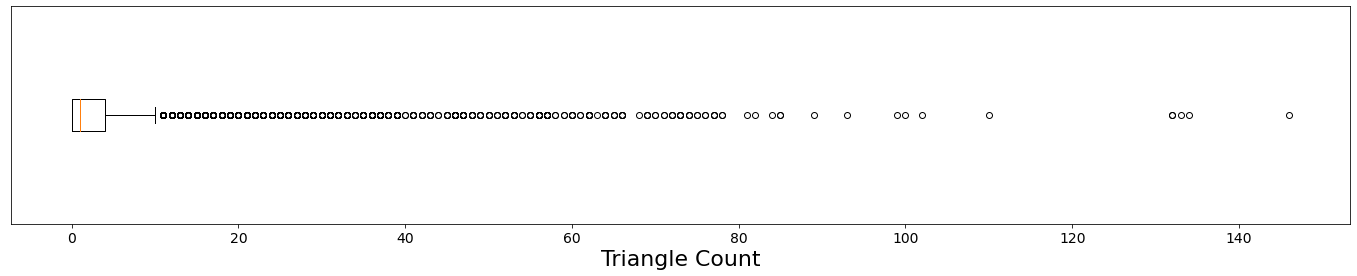

In [49]:
# plot the figure for triangle count value distribution
plt.figure(figsize=(24,4))
plt.boxplot(triangles_cr['count'], vert=False)
plt.xticks(fontsize=14)
plt.yticks([])
plt.xlabel('Triangle Count', fontsize=22)
plt.show()

In [51]:
# choose the top 50 officers with most triangle counts
interested_cr = set(triangles_cr[:50]['id'])

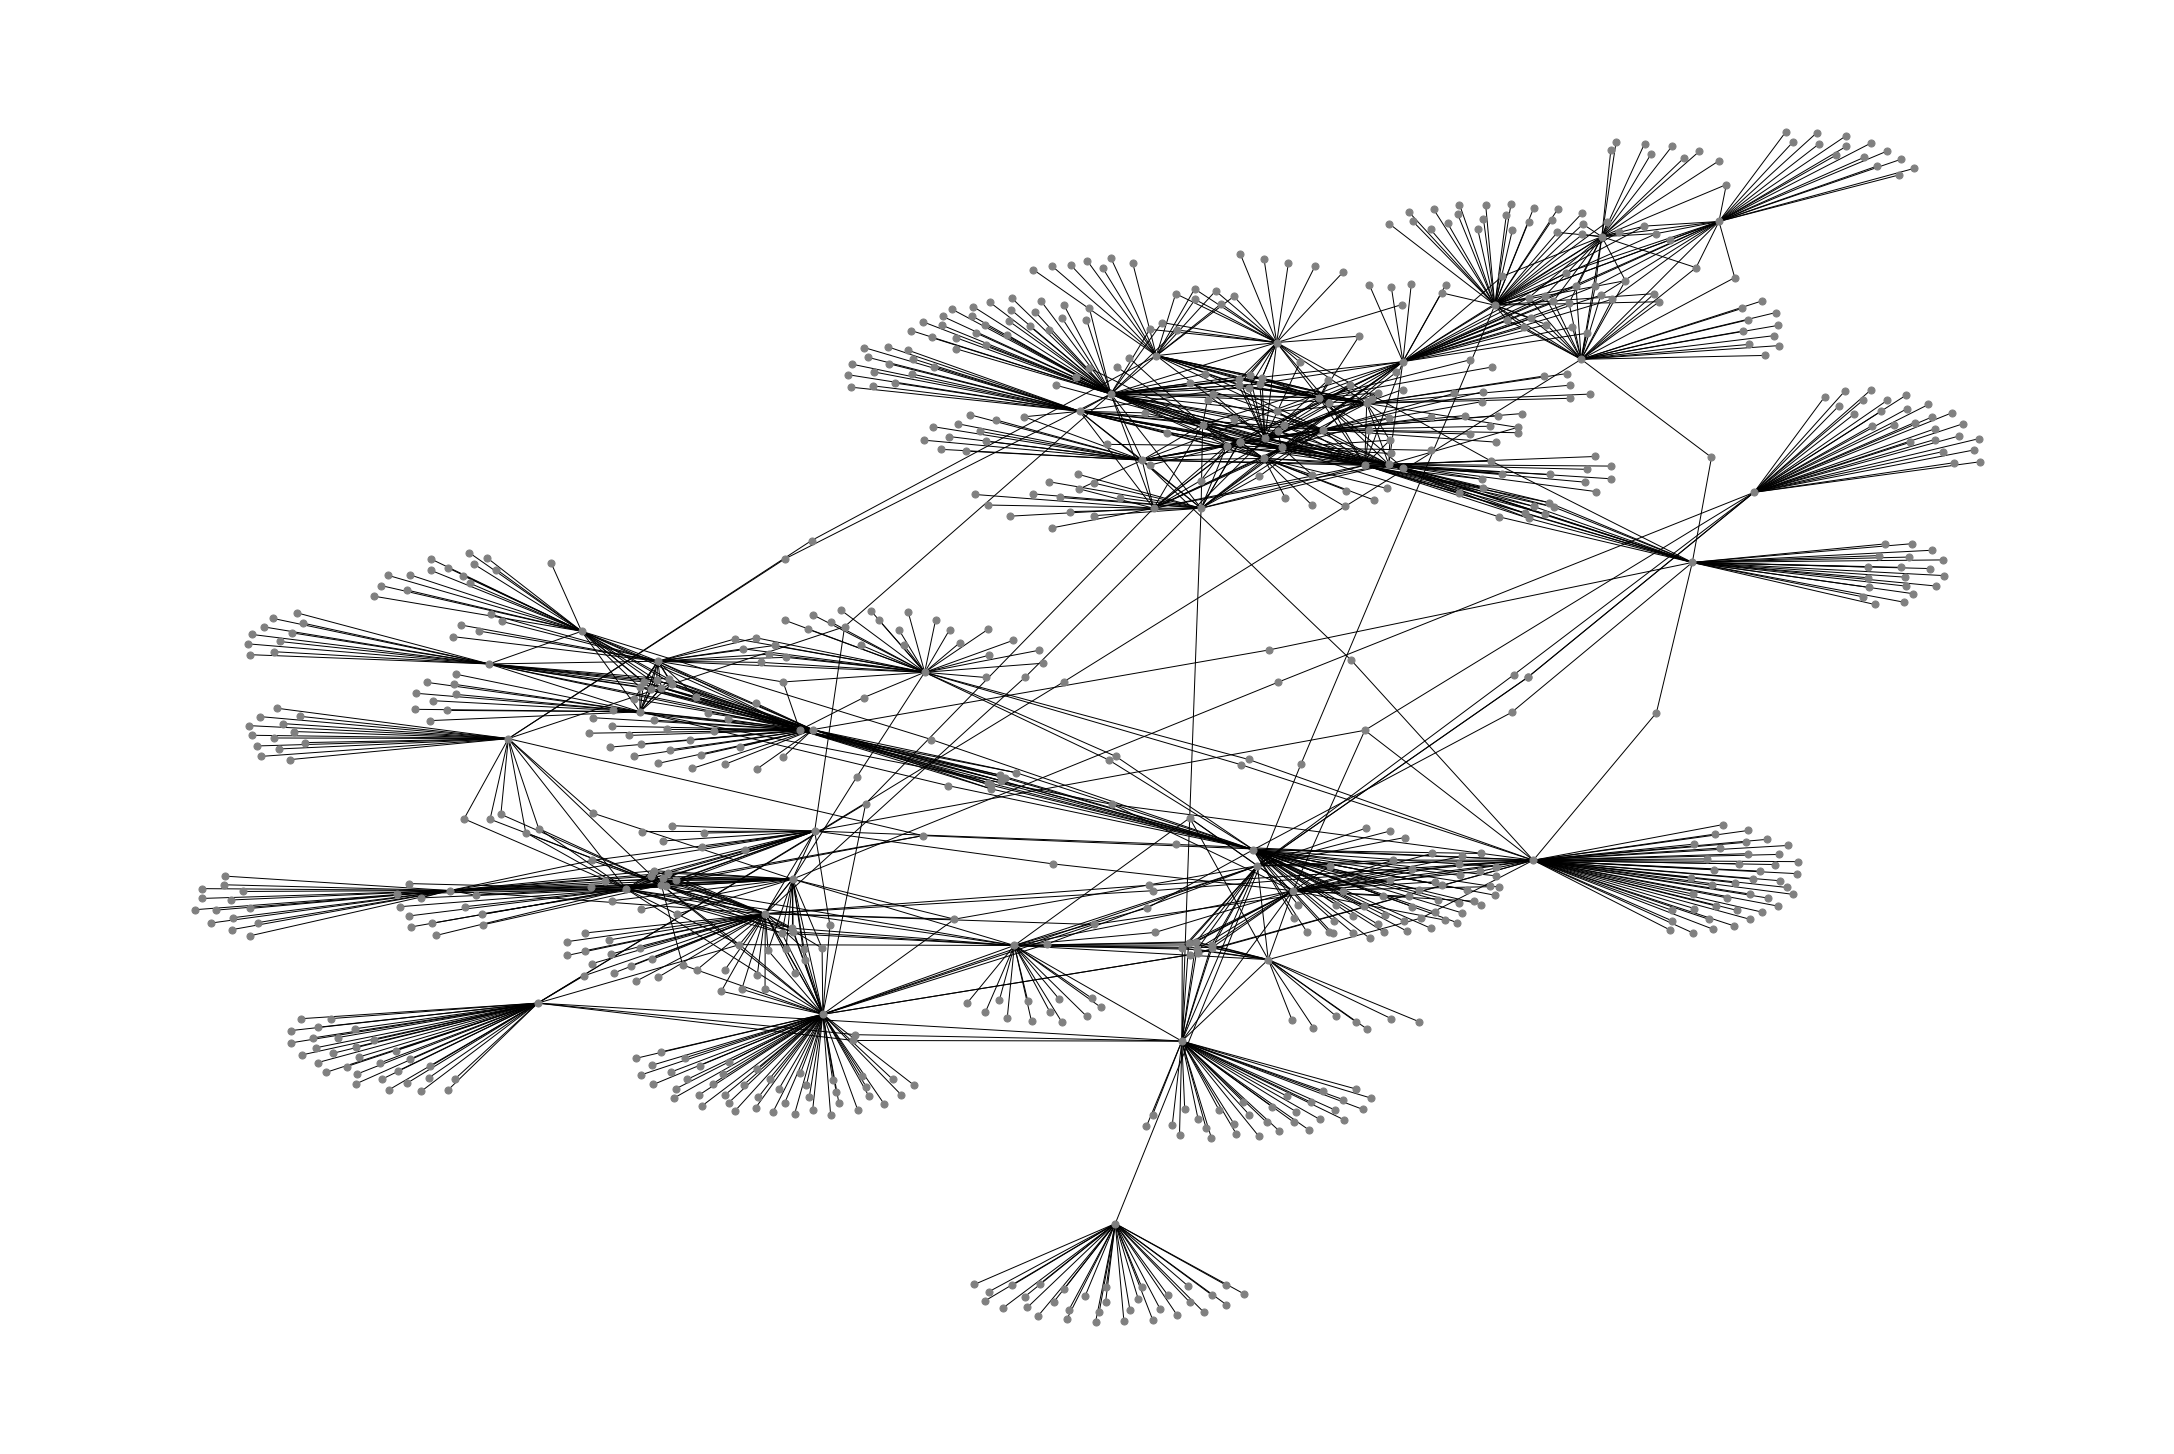

In [52]:
# plot TRR network graph
plot_graph(edges[(edges['src'].isin(interested)) | (edges['dst'].isin(interested))])

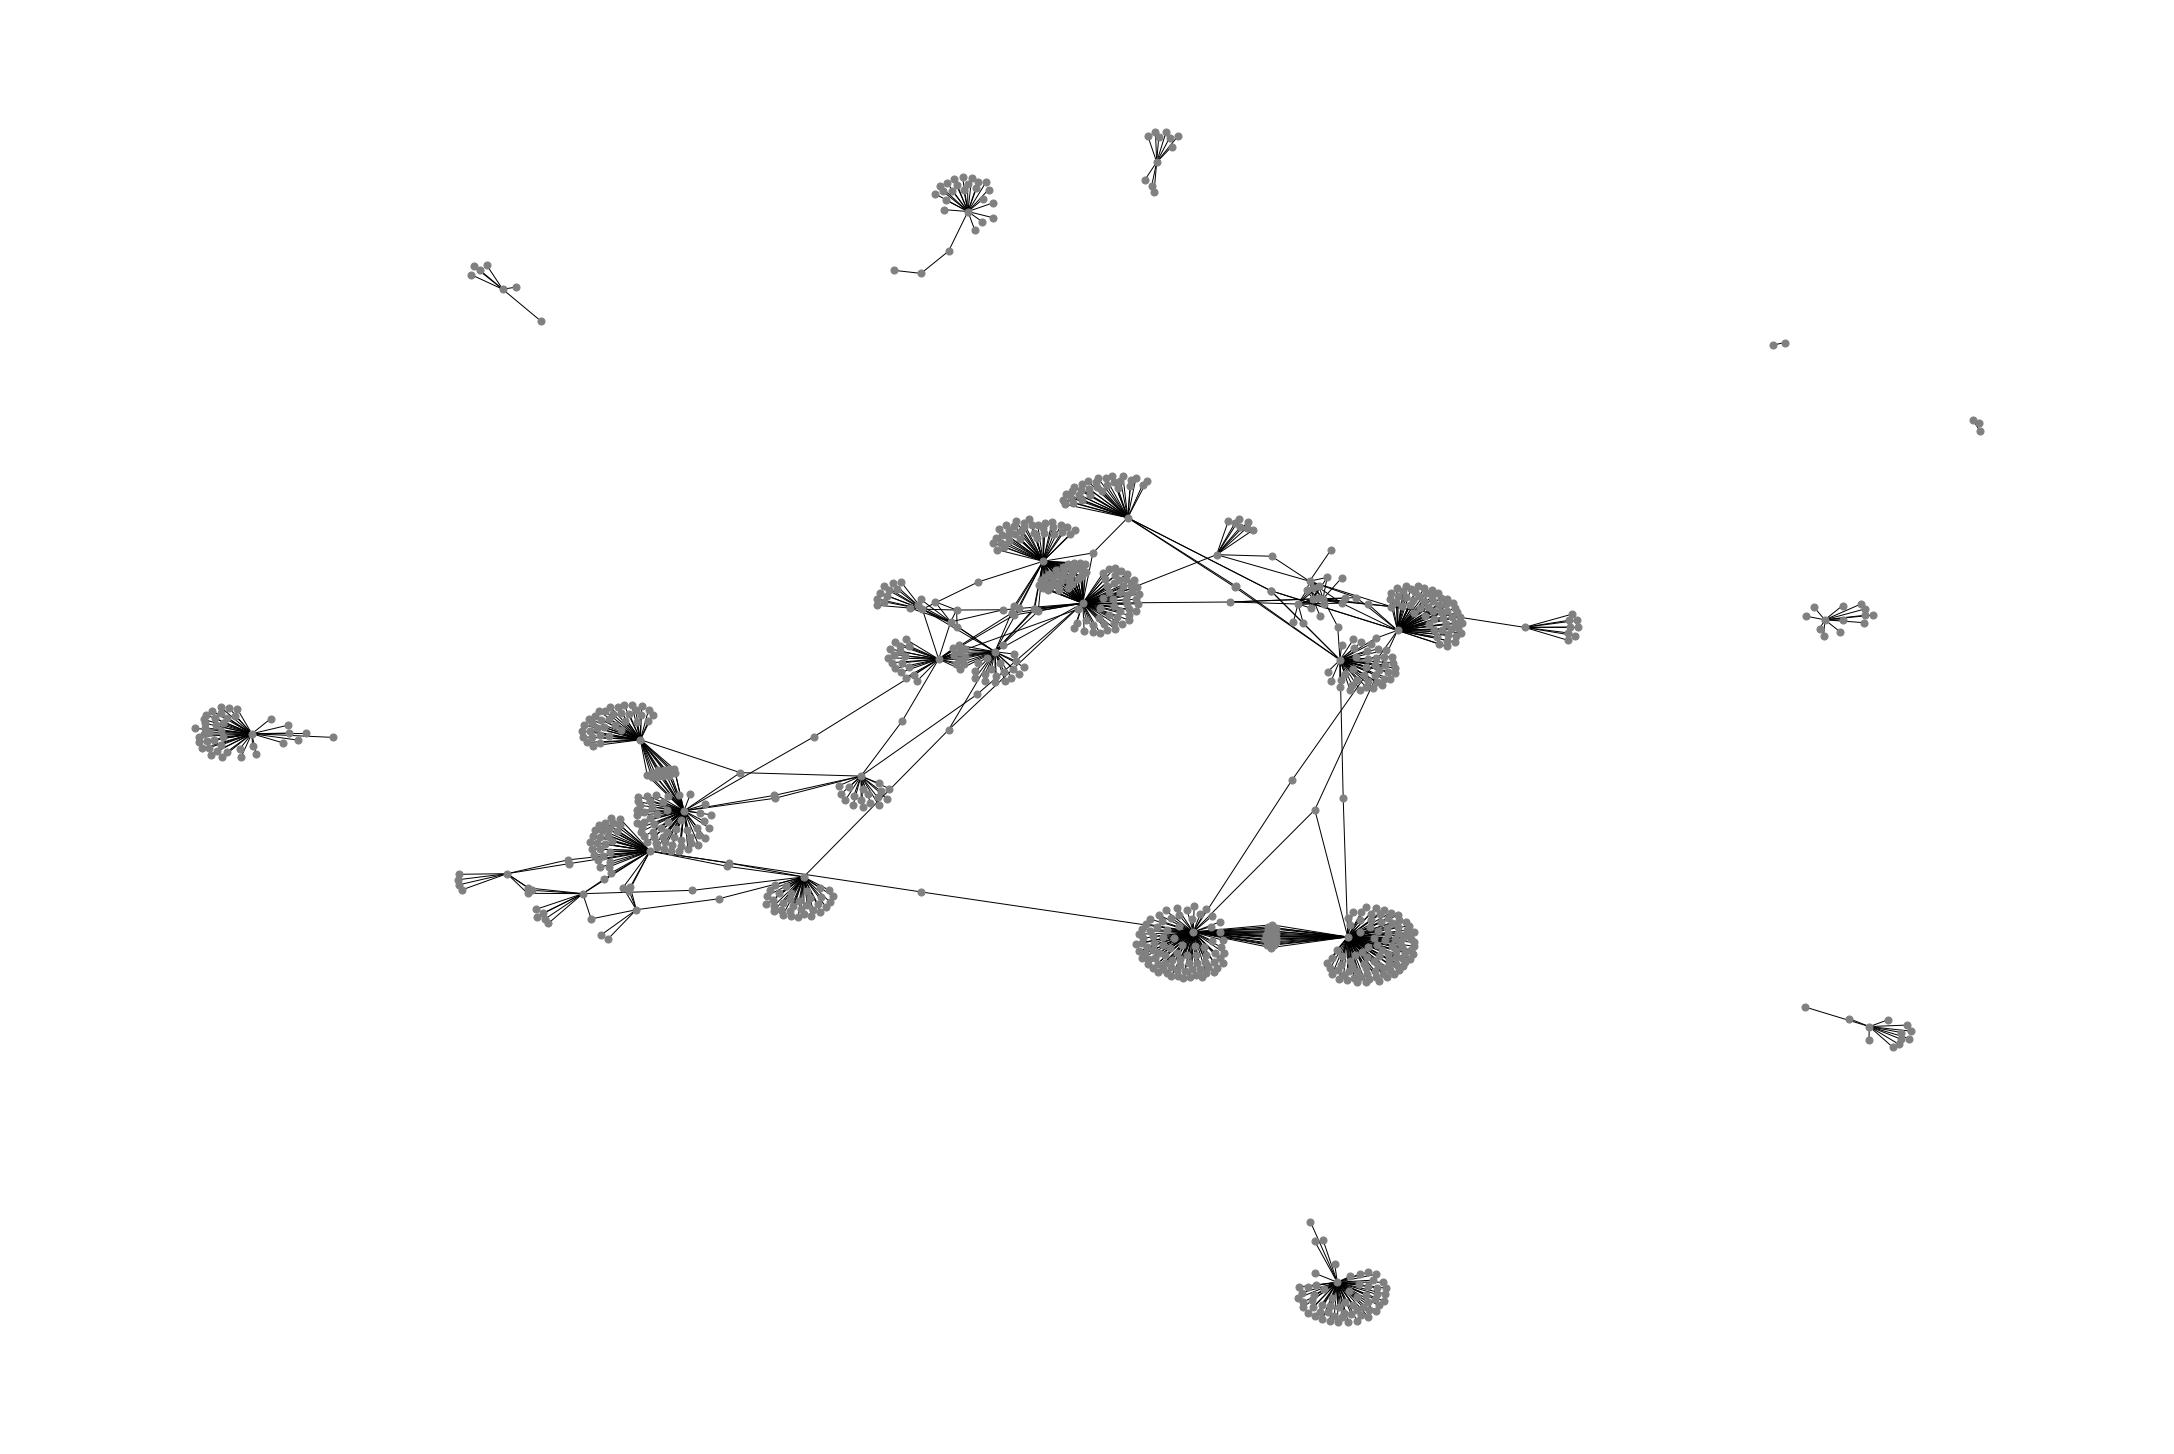

In [55]:
# plot baseline graph
plot_graph(tsedges[(tsedges['src'].isin(interested)) | (tsedges['dst'].isin(interested))])